## Compare rainfall forcing

In [15]:
# Import the correct packages
import os
from pathlib import Path

import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import cartopy.feature as cfeature
import geopandas as gpd
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import xarray as xr
import netCDF4 as nc

import hydromt
from hydromt.log import setuplog

In [16]:
# case study settings
start_date = np.datetime64('2019-03-09T00:00') 
end_date = np.datetime64('2019-03-25T06:00') 

# Define offset for ERA5 & ERA5-Land correction
offset = pd.tseries.frequencies.to_offset("1h")

# Region of case study area in Mozambique
bbox = (34.33,-20.12,34.95,-19.30)
lat = slice(-19.30, -20.12)
lon = slice(34.33, 34.95)

# region of eastern Africa
bbox_big = (29,-27,46,-9)
lat_big = slice(-9, -27)
lon_big = slice(29, 46)

In [17]:
# Reading in ERA5 the data from wflow folder
# era5_hourly = xr.open_dataset(r"p:\wflow_global\hydromt\meteo\era5\tp\era5_tp_2019_hourly.nc", engine='netcdf4')
era5_hourly = xr.open_dataset(r'p:\11210471-001-compass\01_Data\ERA5\Idai\time_corrected\era5_tp.nc', engine='netcdf4')

# select time range and spatial extent
era5_precip_idai  = era5_hourly['tp'].sel(time=slice(start_date, end_date), latitude=lat, longitude=lon)
era5_precip_idai_big = era5_hourly['tp'].sel(time=slice(start_date, end_date), latitude=lat_big, longitude=lon_big)

In [ ]:
# Offset the time by one hour so all the correct hourly time steps in a day are selected
# era5_hourly["time"] = era5_hourly.get_index("time") - offset
# # We store it for ERA5-Land correction
# time_index = era5_hourly["time"]

# era5_precip_idai_big = era5_hourly['tp'].sel(time=slice(start_date, end_date), latitude=lat_big, longitude=lon_big)*1000

# era5_final_corrected = era5_precip_idai_big.to_dataset()

# # Export corrected 1h shifted ERA5, encoding otherwise wflow doesn't run
# chunksizes = (era5_final_corrected.latitude.size, era5_final_corrected.longitude.size, 1)
# encoding = {
#         v: {"zlib": True, "dtype": "float32", "chunksizes": chunksizes}
#         for v in era5_final_corrected.data_vars.keys()
#     }
# encoding["time"] = {"_FillValue": None}

# outfile_path = r'p:\11210471-001-compass\01_Data\ERA5\Idai\time_corrected\era5_tp.nc'
# #%%We save the output
# era5_final_corrected.to_netcdf(outfile_path, encoding=encoding)
# era5_final_corrected.close()
# print("Done")

In [18]:
# Reading in the CHIRPS data
chirps_data = xr.open_dataset(r"p:\wflow_global\hydromt\meteo\chirps_africa_daily_v2.0\CHIRPS_rainfall_2019.nc", engine='netcdf4')
chirps_data = chirps_data.rename({ "lat": "latitude", "lon": "longitude"})

# select time range
chirps_precip_idai     = chirps_data['precipitation'].sel(time=slice(start_date, end_date), latitude=lat, longitude=lon)
chirps_precip_idai_big = chirps_data['precipitation'].sel(time=slice(start_date, end_date), latitude=lat_big, longitude=lon_big)

In [19]:
chirps_data.time

<xarray.DataArray 'time' (time: 365)> Size: 3kB
array(['2019-01-01T00:00:00.000000000', '2019-01-02T00:00:00.000000000',
       '2019-01-03T00:00:00.000000000', ..., '2019-12-29T00:00:00.000000000',
       '2019-12-30T00:00:00.000000000', '2019-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 3kB 2019-01-01 2019-01-02 ... 2019-12-31

In [20]:
# Reading in the TAMSAT data (from https://research.reading.ac.uk/tamsat/data-access/)
tamsat_data     = xr.open_dataset(r"p:\11210471-001-compass\01_Data\TAMSAT\Idai\01-tamsatDaily.v3.1-20190301-20190331-20241002_34.0_35.0_-21.0_-19.0.nc", engine='netcdf4')
tamsat_data_big = xr.open_dataset(r"p:\11210471-001-compass\01_Data\TAMSAT\Idai\Whole_MZ\01-tamsatDaily.v3.1-20190314-20190323-20240821_29.0_46.0_-27.0_-9.0.nc", engine='netcdf4')
# Renaming lat and lon
tamsat_data = tamsat_data.rename({ "lat": "latitude", "lon": "longitude"})
tamsat_data_big = tamsat_data_big.rename({ "lat": "latitude", "lon": "longitude"})

# select time range and filled rainfall variable (non filled is 'rfe)
tamsat_precip_idai     = tamsat_data['rfe_filled'].sel(time=slice(start_date, end_date), latitude=lat, longitude=lon)
tamsat_precip_idai_big = tamsat_data_big['rfe_filled'].sel(time=slice(start_date, end_date), latitude=lat_big, longitude=lon_big)

In [21]:
# Reading in the ERA5-Land data, corrected for time and precip units from m to mm
era5_land = xr.open_dataset(r'p:\11210471-001-compass\01_Data\ERA5_land\units_corrected\era5land_tp_long.nc', engine='netcdf4')

# sum over time range for the study region
era5land_precip_idai     = era5_land['tp'].sel(valid_time=slice(start_date, end_date), latitude=lat, longitude=lon)
era5land_precip_idai_big = era5_land['tp'].sel(valid_time=slice(start_date, end_date), latitude=lat_big, longitude=lon_big)

In [ ]:
# era5_land     = xr.open_dataset(r"p:\11210471-001-compass\01_Data\ERA5_land\Idai_rainfall\era5_land_20190301-20190331_MZregion.nc", engine='netcdf4')
# # era5_land_big = xr.open_dataset(r"p:\11210471-001-compass\01_Data\ERA5_land\Idai_rainfall\ERA5_land_CDSbeta.nc", engine='netcdf4')
# # ERA5 Land data from 9 March, so longer temporal range
# era5_land_big = xr.open_dataset(r"p:\11210471-001-compass\01_Data\ERA5_land\Idai_rainfall\era5_land_MZ_long.nc", engine='netcdf4')

# # To take the correct days we go from 01:00 until 00:00 of the NEXT day, see the link # https://confluence.ecmwf.int/pages/viewpage.action?pageId=197702790
# era5_land["valid_time"] = era5_land.get_index("valid_time") - offset
# era5_land_big["valid_time"] = era5_land_big.get_index("valid_time") - offset
# # ?? Or shift the time back?

# # We create the function and pad with 0 so the output array has the same length
# def diff_len(x):
#     return np.diff(x, n=1, prepend=0)

# # We use the .resample() and assign the correct time index
# ds= era5_land.resample(valid_time="D")
# era5_land_corr = xr.apply_ufunc(
#     # function to apply
#     diff_len,
#     # object with data to pass to function
#     ds,
#     input_core_dims=[['valid_time']],
#     output_core_dims = [['valid_time']])

# # Do the same for the ERA5-Land for the whole region of eastern Africa
# ds= era5_land_big.resample(valid_time="D")
# era5_land_big_corr = xr.apply_ufunc(
#     # function to apply
#     diff_len,
#     # object with data to pass to function
#     ds,
#     input_core_dims=[['valid_time']],
#     output_core_dims = [['valid_time']])

# # sum over time range for the study region and change total rainfall unit from m to mm
# era5land_precip_idai     = era5_land_corr['tp'].sel(valid_time=slice(start_date, end_date), latitude=lat, longitude=lon)*1000
# era5land_precip_idai_big = era5_land_big_corr['tp'].sel(valid_time=slice(start_date, end_date), latitude=lat_big, longitude=lon_big)*1000

# # Save the corrected ERA5-Land to a dataset
# era5land_final_corrected = era5land_precip_idai_big.to_dataset()

# # Export corrected ERA5-Land, encoding otherwise wflow doesn't run
# chunksizes = (era5land_final_corrected.latitude.size, era5land_final_corrected.longitude.size, 1)
# encoding = {
#         v: {"zlib": True, "dtype": "float32", "chunksizes": chunksizes}
#         for v in era5land_final_corrected.data_vars.keys()
#     }
# encoding["valid_time"] = {"_FillValue": None}

# outfile_path = r'p:\11210471-001-compass\01_Data\ERA5_land\units_corrected\era5land_tp_long.nc'
# #%%We save the output
# era5land_final_corrected.to_netcdf(outfile_path, encoding=encoding)
# era5land_final_corrected.close()
# print("Done")

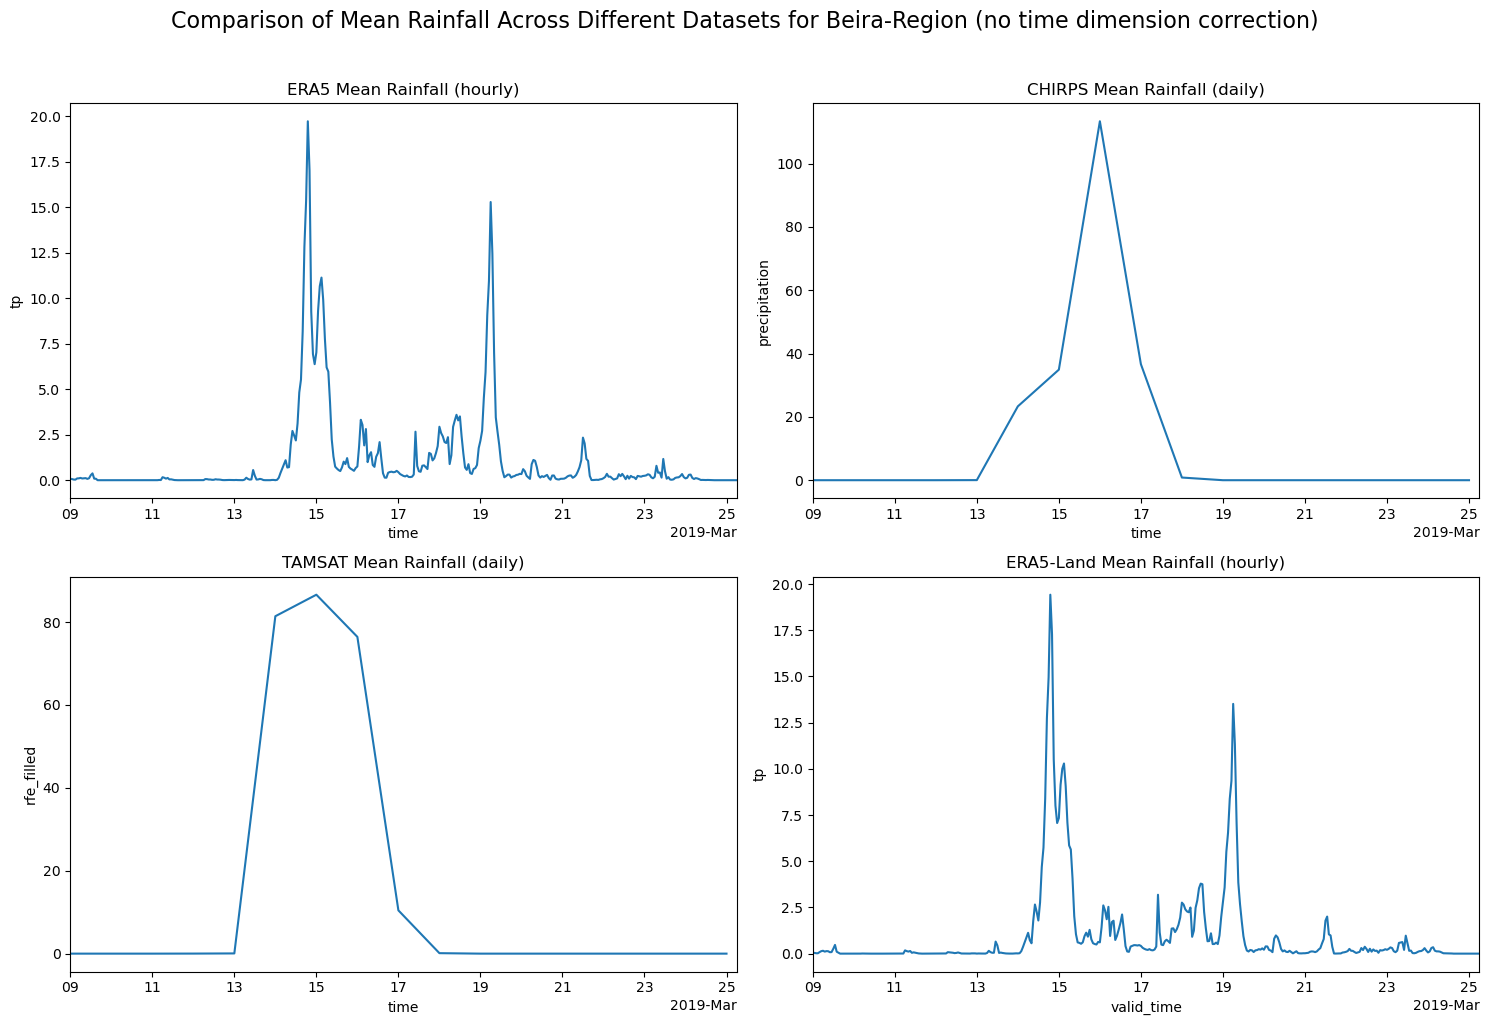

In [22]:
# Set up the subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

fig.suptitle('Comparison of Mean Rainfall Across Different Datasets for Beira-Region (no time dimension correction)', fontsize=16, y=1.02)

# Plot each dataset in separate subplots
datasets = [
    (era5_precip_idai, "ERA5 Mean Rainfall (hourly)"),
    (chirps_precip_idai, "CHIRPS Mean Rainfall (daily)"),
    (tamsat_precip_idai, "TAMSAT Mean Rainfall (daily)"),
    (era5land_precip_idai, "ERA5-Land Mean Rainfall (hourly)")
]

for ax, (data, title) in zip(axes.flatten(), datasets):

    # Calculate the spatial mean
    mean_data = data.mean(dim=['latitude', 'longitude'])

    # Plot the mean data
    mean_data.plot(ax=ax)
    ax.set_title(title)
    ax.set_xlim(start_date, end_date)

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

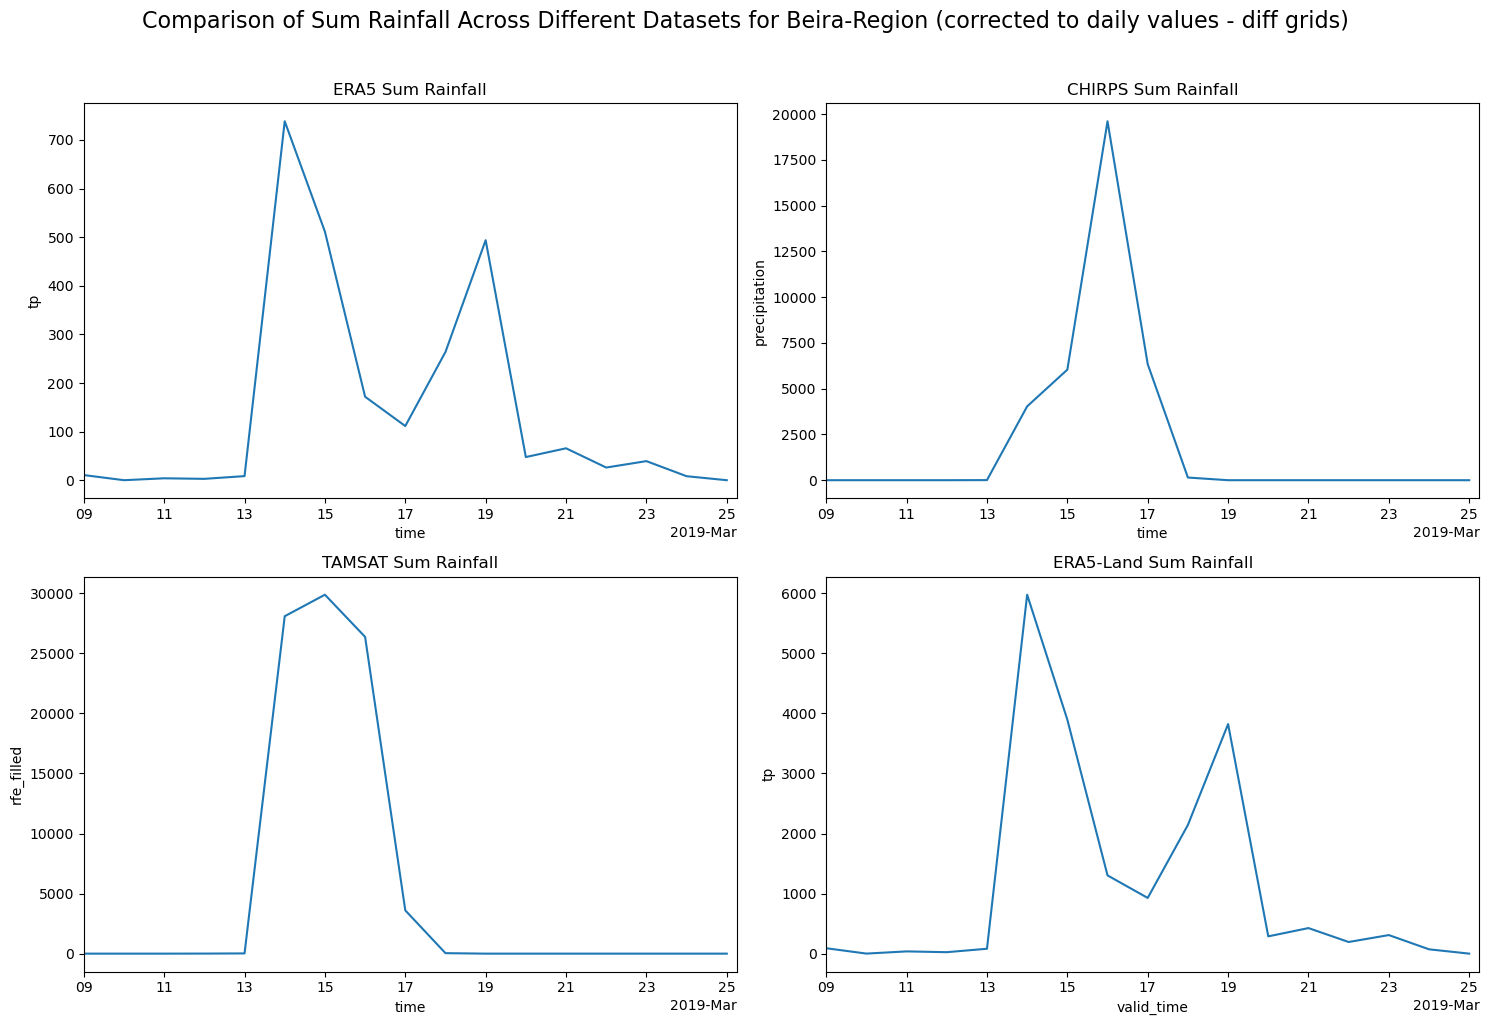

In [23]:
# Set up the subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

fig.suptitle('Comparison of Sum Rainfall Across Different Datasets for Beira-Region (corrected to daily values - diff grids)', fontsize=16, y=1.02)

# Plot each dataset in separate subplots
datasets = [
    (era5_precip_idai, "ERA5 Sum Rainfall"),
    (chirps_precip_idai, "CHIRPS Sum Rainfall"),
    (tamsat_precip_idai, "TAMSAT Sum Rainfall"),
    (era5land_precip_idai, "ERA5-Land Sum Rainfall"),
]

for ax, (data, title) in zip(axes.flatten(), datasets):
    # Convert to daily data, to align all datsets
    if 'time' in data.dims:
        daily_data = data.resample(time='D').sum()
    elif 'valid_time' in data.dims:
        daily_data = data.resample(valid_time='D').sum()

    # Calculate mean using 'latitude' and 'longitude'
    # mean_data = daily_data.mean(dim=['latitude', 'longitude'])
    summed_data = daily_data.sum(dim=['latitude', 'longitude'])


    # Plot the mean data
    summed_data.plot(ax=ax)
    ax.set_title(title)
    ax.set_xlim(start_date, end_date)

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

## Note: ERA5 & the ISIMIP datasets account for rainfall over the ocean, leading to higher values

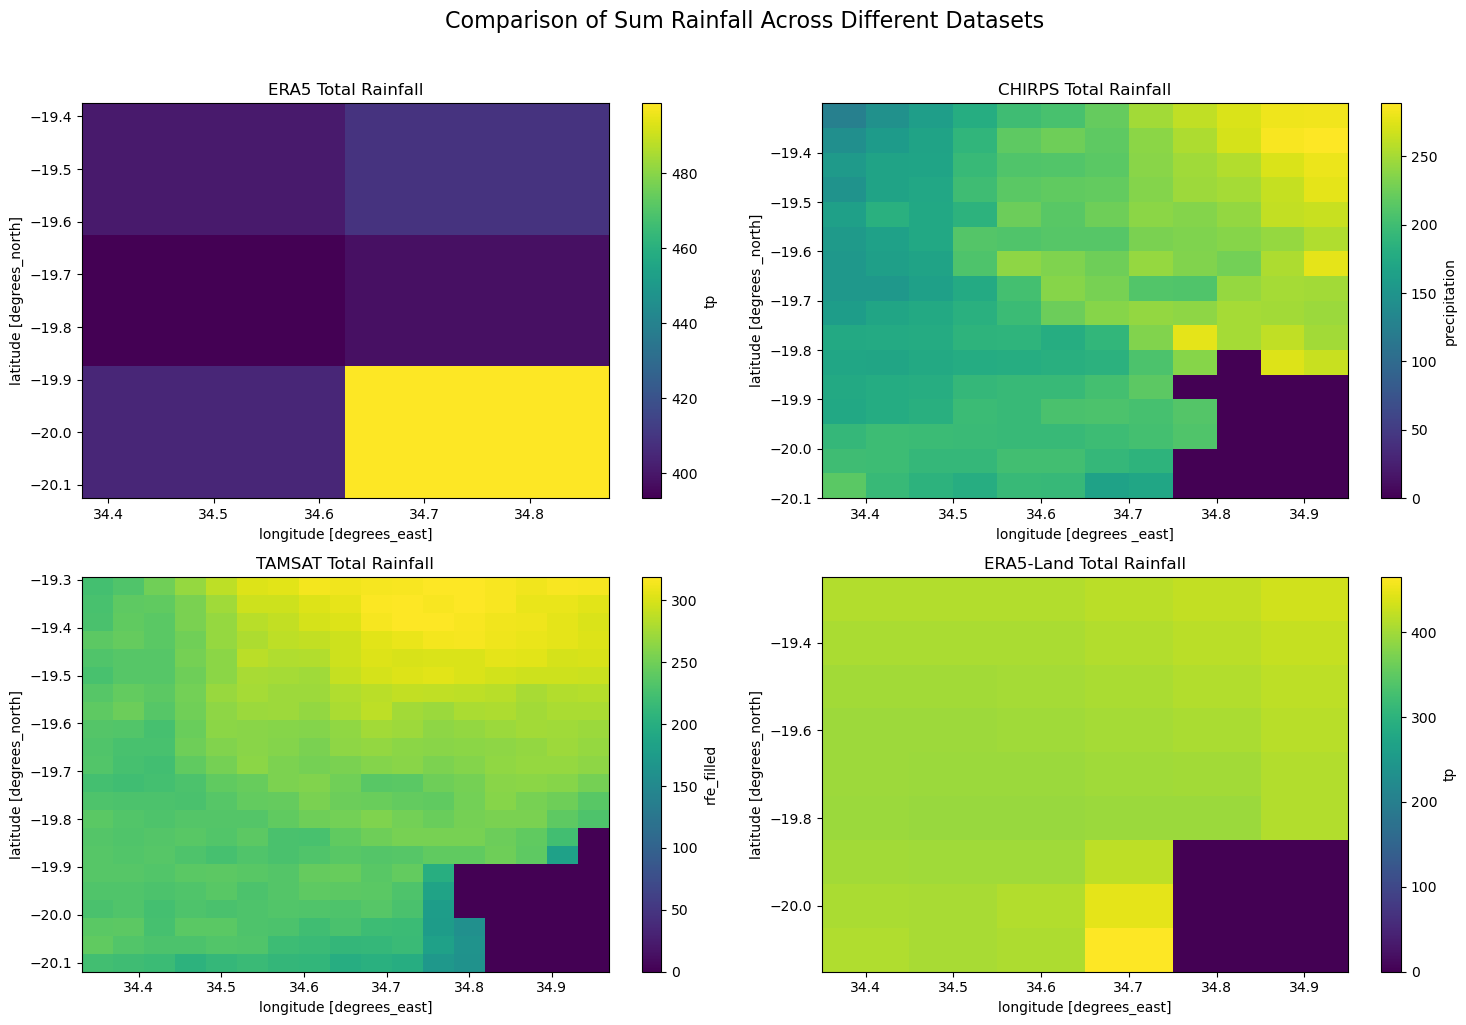

In [25]:
# Set up the subplots for the case study area
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

fig.suptitle('Comparison of Sum Rainfall Across Different Datasets', fontsize=16, y=1.02)

# Plot each dataset in separate subplots
datasets = [
    (era5_precip_idai, "ERA5 Total Rainfall"),
    (chirps_precip_idai, "CHIRPS Total Rainfall"),
    (tamsat_precip_idai, "TAMSAT Total Rainfall"),
    (era5land_precip_idai, "ERA5-Land Total Rainfall")
]

for ax, (data, title) in zip(axes.flatten(), datasets):
    if 'time' in data.dims:
        sum_data = data.sum(dim='time')
    elif 'valid_time' in data.dims:
        sum_data = data.sum(dim='valid_time')

    # Plot the mean data
    sum_data.plot(ax=ax)
    ax.set_title(title)

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

## Note: ERA5 & the ISIMIP datasets account for rainfall over the ocean, leading to higher values

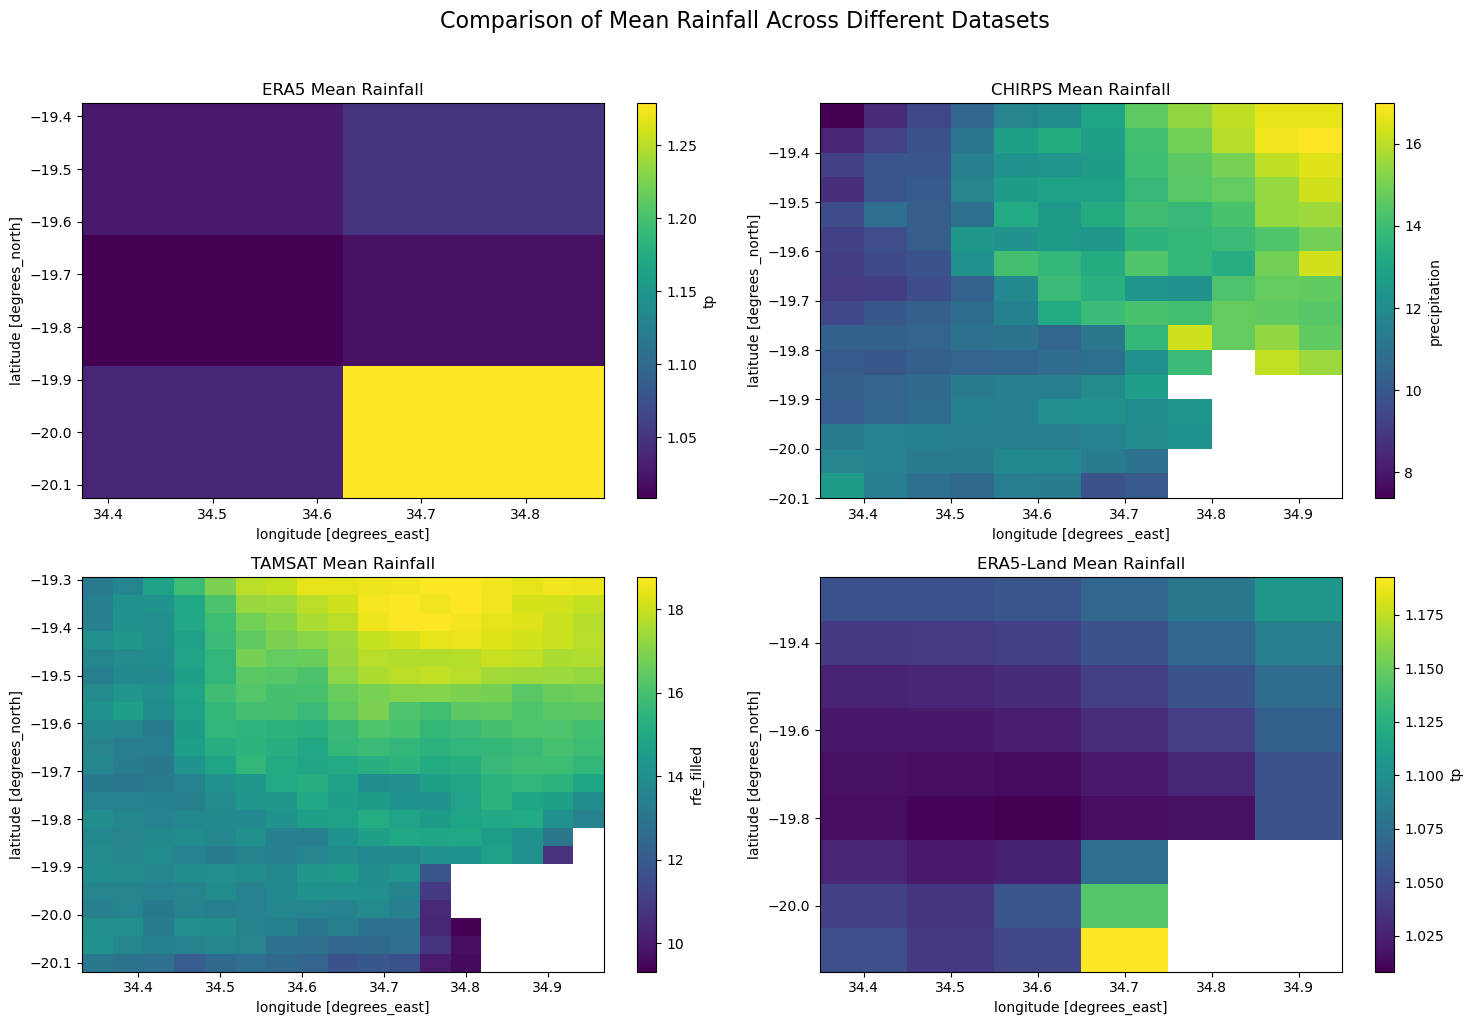

In [26]:
# Set up the subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

fig.suptitle('Comparison of Mean Rainfall Across Different Datasets', fontsize=16, y=1.02)

# Plot each dataset in separate subplots
datasets = [
    (era5_precip_idai, "ERA5 Mean Rainfall"),
    (chirps_precip_idai, "CHIRPS Mean Rainfall"),
    (tamsat_precip_idai, "TAMSAT Mean Rainfall"),
    (era5land_precip_idai, "ERA5-Land Mean Rainfall")
]

for ax, (data, title) in zip(axes.flatten(), datasets):
    if 'time' in data.dims:
        mean_data = data.mean(dim='time')
    elif 'valid_time' in data.dims:
        mean_data = data.mean(dim='valid_time')

    # Plot the mean data
    mean_data.plot(ax=ax)
    ax.set_title(title)

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

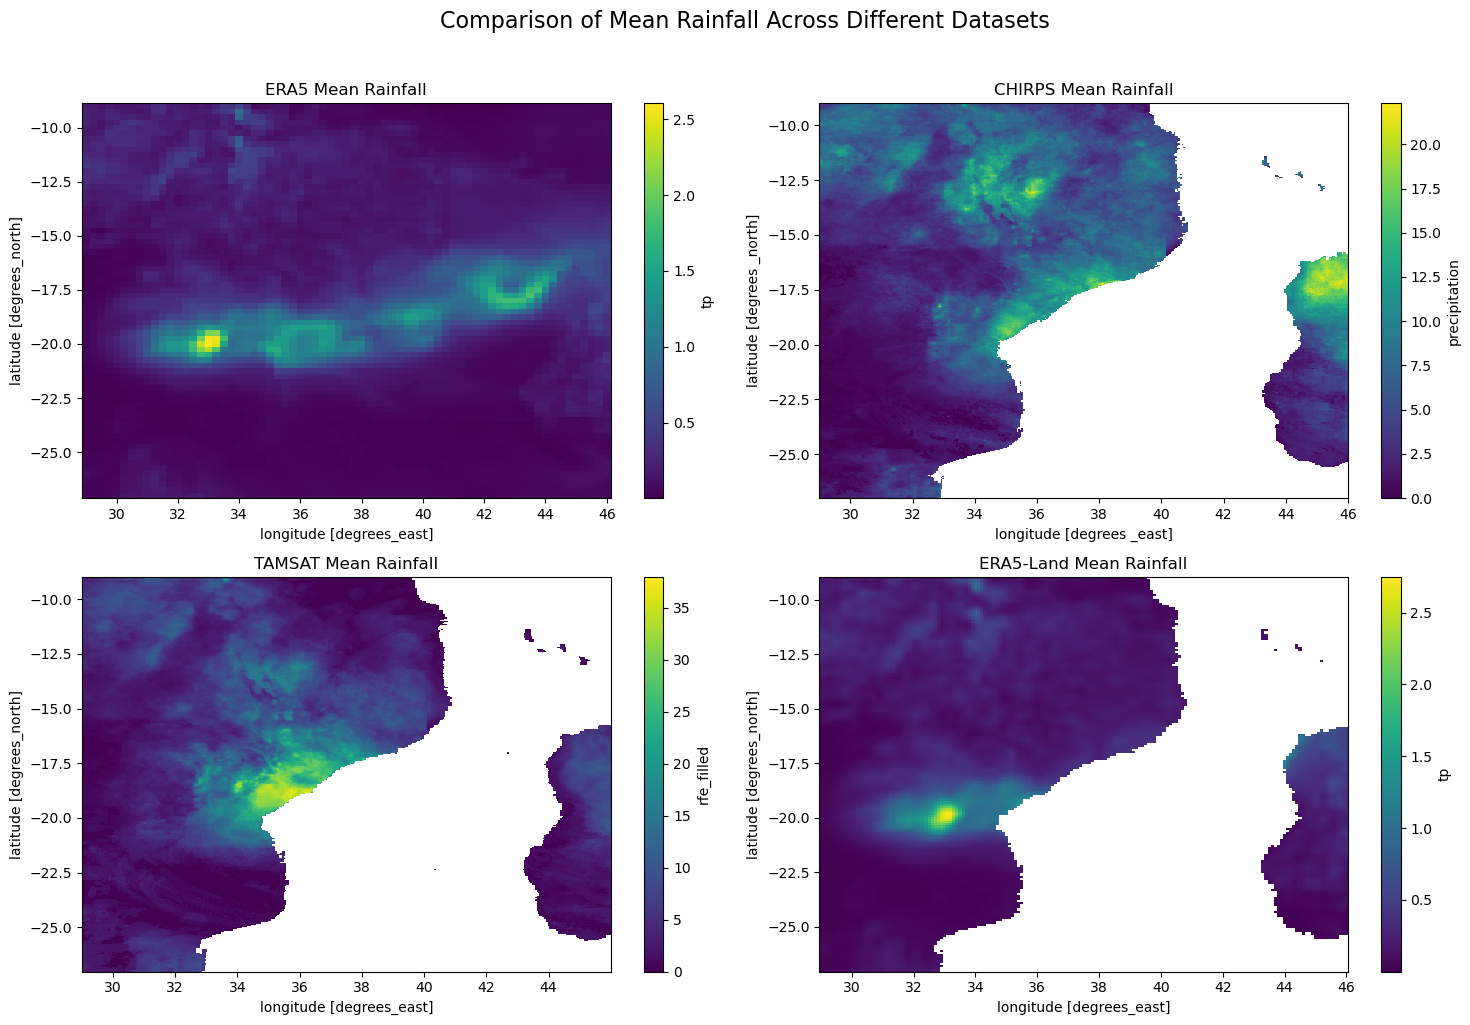

In [27]:
# Set up the subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

fig.suptitle('Comparison of Mean Rainfall Across Different Datasets', fontsize=16, y=1.02)

# Plot each dataset in separate subplots
datasets = [
    (era5_precip_idai_big, "ERA5 Mean Rainfall"),
    (chirps_precip_idai_big, "CHIRPS Mean Rainfall"),
    (tamsat_precip_idai_big, "TAMSAT Mean Rainfall"),
    (era5land_precip_idai_big, "ERA5-Land Mean Rainfall")
    
]

# Calculate the mean of rainfall over time
for ax, (data, title) in zip(axes.flatten(), datasets):
    if 'time' in data.dims:
        mean_data = data.mean(dim='time')
    elif 'valid_time' in data.dims:
        mean_data = data.mean(dim='valid_time')

    # Plot the mean data
    mean_data.plot(ax=ax)
    ax.set_title(title)

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

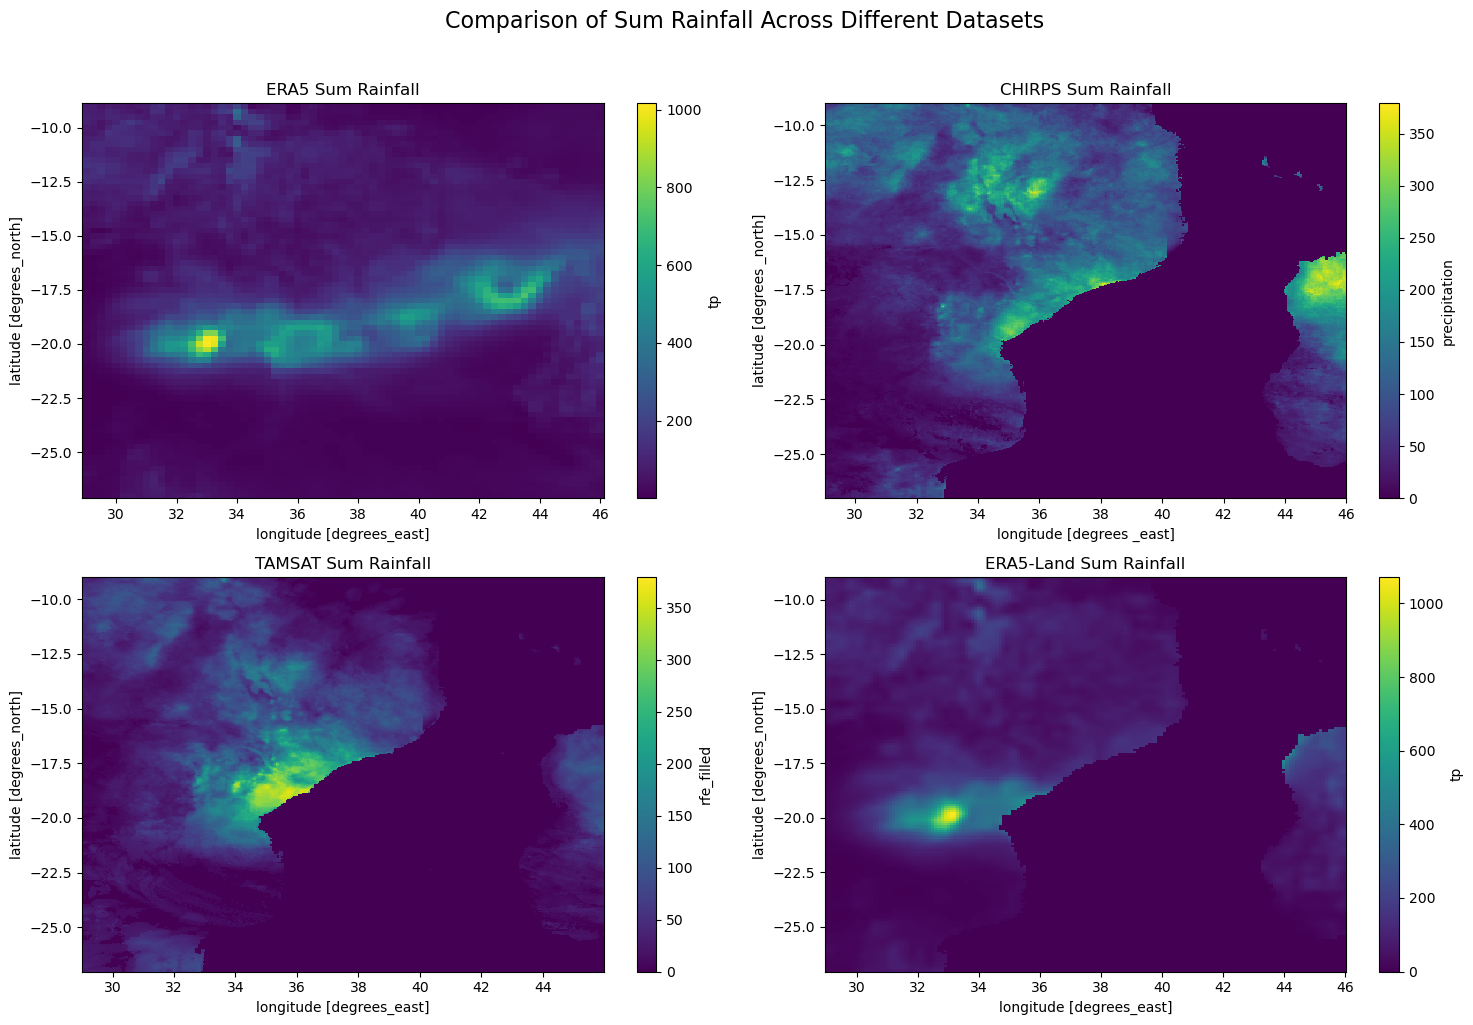

In [28]:
# Set up the subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

fig.suptitle('Comparison of Sum Rainfall Across Different Datasets', fontsize=16, y=1.02)

# Plot each dataset in separate subplots
datasets = [
    (era5_precip_idai_big, "ERA5 Sum Rainfall"),
    (chirps_precip_idai_big, "CHIRPS Sum Rainfall"),
    (tamsat_precip_idai_big, "TAMSAT Sum Rainfall"),
    (era5land_precip_idai_big, "ERA5-Land Sum Rainfall")
]

# Calculate the mean of rainfall over time, can be changed to calculate the sum
for ax, (data, title) in zip(axes.flatten(), datasets):
    if 'time' in data.dims:
        mean_data = data.sum(dim='time')
    elif 'valid_time' in data.dims:
        mean_data = data.sum(dim='valid_time')

    # Plot the mean data
    mean_data.plot(ax=ax)
    ax.set_title(title)

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

In [ ]:
# Set up the subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

fig.suptitle('Comparison of Sum Rainfall Across Different Datasets', fontsize=16, y=1.02)

# Plot each dataset in separate subplots
datasets = [
    (era5_precip_idai_big, "ERA5 Sum Rainfall"),
    (chirps_precip_idai_big, "CHIRPS Sum Rainfall"),
    (tamsat_precip_idai_big, "TAMSAT Sum Rainfall"),
    (era5land_precip_idai_big, "ERA5-Land Sum Rainfall")
]

# Calculate the mean of rainfall over time, can be changed to calculate the sum
for ax, (data, title) in zip(axes.flatten(), datasets):
    if 'time' in data.dims:
        mean_data = data.sum(dim='time')
    elif 'valid_time' in data.dims:
        mean_data = data.sum(dim='valid_time')

    # Plot the mean data
    mean_data.plot(ax=ax)
    ax.set_title(title)

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

## Using hydromt to avoid mistakes

In [17]:
path_data_cat = "C:/Code/COMPASS/Workflows/03_data_catalogs/datacatalog_general.yml"
wflow_region  = "p:/11210471-001-compass/02_Models/sofala/Idai/wflow/staticgeoms/region.geojson"

region = gpd.read_file(wflow_region)
print(region)
 
# Read data catalog
data_catalog = hydromt.data_catalog.DataCatalog(data_libs = path_data_cat)

# Read the region that needs precipitation input
region = gpd.read_file(wflow_region)


# Pass as a time tuple for HydroMT
time_range = (start_date, end_date)
#%%
# Load raster data for specified region and time range
# Original data catalog entry for era5_hourly using lock:false
era5_tp = data_catalog.get_rasterdataset(
    data_like = 'era5_hourly',
    time_tuple = time_range,
    variables = 'precip',
    bbox=[29, -27, 46, -9]
)

                                            geometry
0  POLYGON ((32.375 -20.94167, 32.375 -17.525, 35...


In [16]:
era5_land_tp = data_catalog.get_rasterdataset(
    data_like = 'ERA5land_Idai_CF0',
    time_tuple = time_range,
    variables = 'precip',
    bbox=[29, -27, 46, -9]
)

In [14]:
chirps_tp = data_catalog.get_rasterdataset(
    data_like = 'chirps',
    time_tuple = time_range,
    variables = 'precip',
    bbox=[29, -27, 46, -9]
)

In [ ]:
tamsat_tp = data_catalog.get_rasterdataset(
    data_like = 'TAMSAT_Idai',
    time_tuple = time_range,
    variables = 'precip',
    bbox=[29, -27, 46, -9]
)

Dataset [33.99375079199672, -21.01875004544854, 35.006249222904444, -18.993750769644976] does not fully cover bbox [29.000, -27.000, 46.000, -9.000]


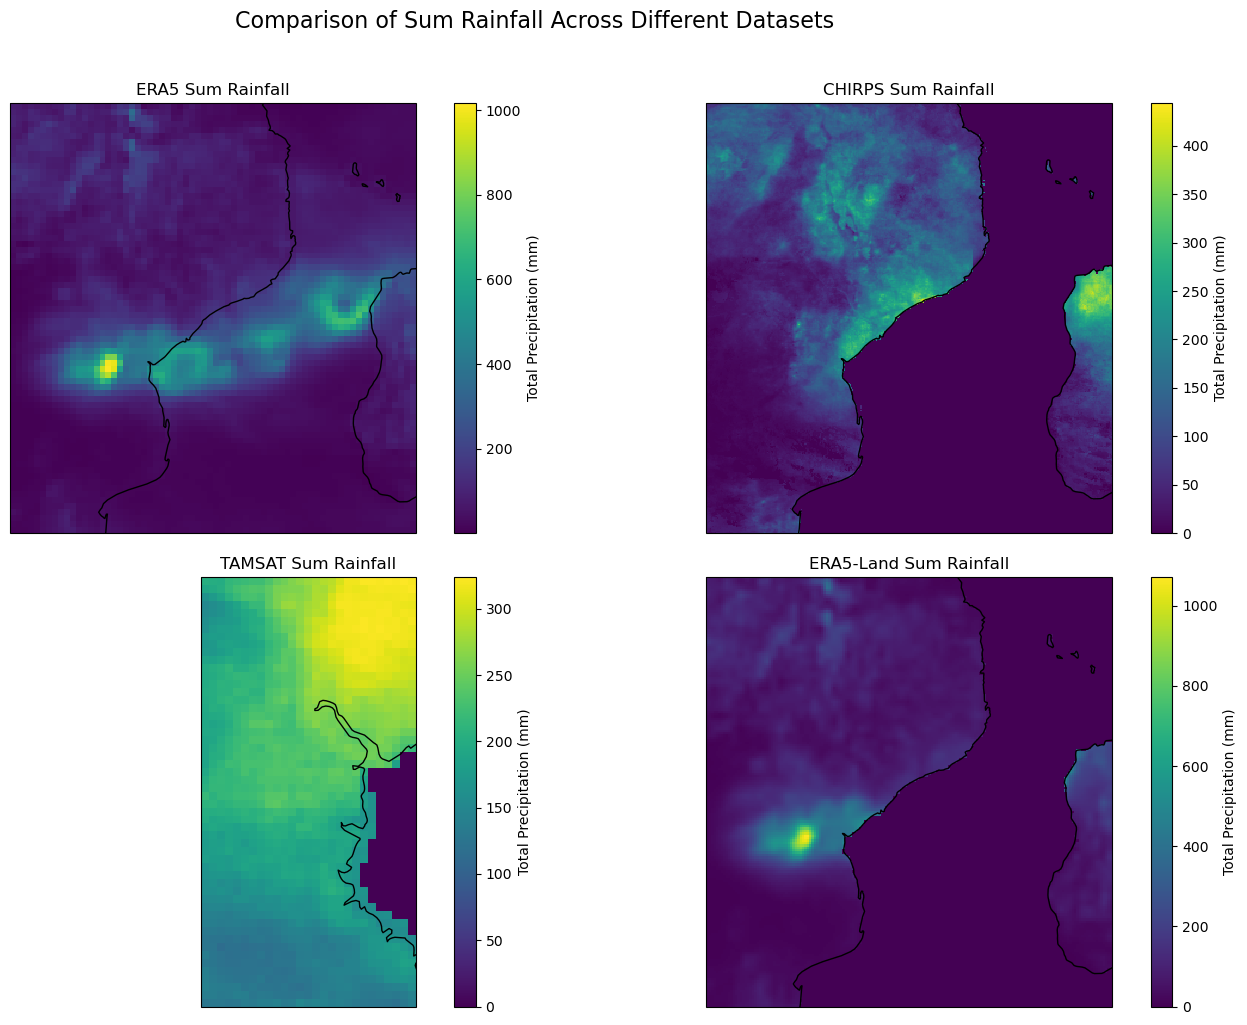

In [18]:
# Set up the subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10), subplot_kw={"projection": ccrs.PlateCarree()})

fig.suptitle('Comparison of Sum Rainfall Across Different Datasets', fontsize=16, y=1.02)

# Plot each dataset in separate subplots
datasets = [
    (era5_tp, "ERA5 Sum Rainfall"),
    (chirps_tp, "CHIRPS Sum Rainfall"),
    (tamsat_tp, "TAMSAT Sum Rainfall"),
    (era5_land_tp, "ERA5-Land Sum Rainfall")
]

# Calculate the sum of rainfall over time
for ax, (data, title) in zip(axes.flatten(), datasets):
    if 'time' in data.dims:
        mean_data = data.sum(dim='time')
    elif 'valid_time' in data.dims:
        mean_data = data.sum(dim='valid_time')

    # Plot the mean data — remove `projection=...`
    mean_data.plot(
        ax=ax,
        cmap='viridis',
        add_colorbar=True,
        cbar_kwargs={'label': 'Total Precipitation (mm)'}
    )

    ax.set_title(title)
    ax.coastlines()  # Optional: add coastlines

plt.tight_layout()
plt.show()


In [ ]:
# Set up the subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

fig.suptitle('Comparison of Sum Rainfall Across Different Datasets', fontsize=16, y=1.02)

# Plot each dataset in separate subplots
datasets = [
    (era5_tp, "ERA5 Sum Rainfall"),
    (chirps_precip_idai_big, "CHIRPS Sum Rainfall"),
    (tamsat_precip_idai_big, "TAMSAT Sum Rainfall"),
    (era5land_precip_idai_big, "ERA5-Land Sum Rainfall")
]

# Calculate the mean of rainfall over time, can be changed to calculate the sum
for ax, (data, title) in zip(axes.flatten(), datasets):
    if 'time' in data.dims:
        mean_data = data.sum(dim='time')
    elif 'valid_time' in data.dims:
        mean_data = data.sum(dim='valid_time')

    # Plot the mean data
    mean_data.plot(ax=ax)
    ax.set_title(title)

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patheffects as pe
from cartopy.io.shapereader import Reader, natural_earth
import netCDF4 as nc
# from ibtracs import Ibtracs
from mpl_toolkits.axes_grid1 import make_axes_locatable
import traceback

class StormFromCSV:
    """
    A simple class to mimic the IBTrACS storm object when loading from CSV.
    """

    def __init__(self, name, season, lats, lons, times, winds, basin="SI"):
        self.name = str(name)
        self.season = int(season)
        self.lats = np.array(lats, dtype=float)
        self.lons = np.array(lons, dtype=float)
        self.times = (
            pd.to_datetime(times) if not isinstance(times, pd.DatetimeIndex) else times
        )
        # Handle wind data more carefully - preserve NaN values
        if isinstance(winds, (list, tuple, np.ndarray)):
            winds_array = np.array(
                winds, dtype=float
            )  # This will convert to float, keeping NaN
            self.wind = winds_array
        else:
            self.wind = np.array(
                [float(winds) if not np.isnan(float(winds)) else np.nan]
            )
        self.basin = str(basin)
        # Set genesis to first time point if available
        if len(self.times) > 0:
            self.genesis = (
                self.times.iloc[0] if hasattr(self.times, "iloc") else self.times[0]
            )
        else:
            self.genesis = None


def load_cyclone_from_csv(csv_file_path, name, year, filter_dates=None):
    """
    Load cyclone data from CSV file.

    Parameters:
    -----------
    csv_file_path : str
        Path to the IBTrACS CSV file
    name : str
        Storm name
    year : int
        Year/season of the storm
    filter_dates : str or tuple/list of str, optional
        Date or date range to filter the cyclone track data.
        - If a single string (e.g., "YYYY-MM-DD"): Show track for this specific day.
        - If a tuple/list of two strings (e.g., ["YYYY-MM-DD", "YYYY-MM-DD"]): Show track for this date range (inclusive).
        Default is None (no date filtering).

    Returns:
    --------
    StormFromCSV object or None
    """
    try:
        # Read CSV file with better dtype handling
        df = pd.read_csv(csv_file_path, low_memory=False)

        # Convert SEASON column to numeric to handle string years like '2023'
        df["SEASON"] = pd.to_numeric(df["SEASON"], errors="coerce")

        # Filter for the specific storm
        storm_data = df[(df["NAME"] == name.upper()) & (df["SEASON"] == year)].copy()

        if storm_data.empty:
            print("No data found for {} in {}".format(name, year))
            return None

        # Ensure LAT and LON are numeric (float), coercing errors to NaN
        # This conversion should happen before dropna
        for col_name in ["LAT", "LON"]:
            if col_name in storm_data.columns:
                storm_data[col_name] = pd.to_numeric(
                    storm_data[col_name], errors="coerce"
                )
            else:
                print(
                    "Warning: Column {} not found for {} ({}) before type conversion.".format(
                        col_name, name, year
                    )
                )

        # Clean and process the data
        storm_data = storm_data.dropna(subset=["LAT", "LON"])

        if storm_data.empty:
            print("No valid coordinate data for {} ({})".format(name, year))
            return None

        # Sort by time
        storm_data["datetime"] = pd.to_datetime(storm_data["ISO_TIME"])
        storm_data = storm_data.sort_values("datetime")

        # Keep a copy of original data before filtering
        storm_data_orig = storm_data.copy()

        # Extract the data
        lats = storm_data["LAT"].values
        lons = storm_data["LON"].values
        times = storm_data["datetime"]

        # Apply date filtering if requested
        if filter_dates and len(times) > 0:
            try:
                mask = np.full(len(times), False)  # Default to no points
                if isinstance(filter_dates, str):  # Single date
                    try:
                        target_date = pd.to_datetime(filter_dates).normalize()
                        mask = (times >= target_date) & (
                            times < target_date + pd.Timedelta(days=1)
                        )
                    except ValueError:
                        print(
                            "Warning: Invalid single date format for filter_dates: {}. Skipping filtering for this storm.".format(
                                filter_dates
                            )
                        )
                        mask = np.full(len(times), True)
                elif (
                    isinstance(filter_dates, (list, tuple)) and len(filter_dates) == 2
                ):  # Date range
                    try:
                        start_date = pd.to_datetime(filter_dates[0]).normalize()
                        # Inclusive end: set to end of the day
                        end_date = (
                            pd.to_datetime(filter_dates[1]).normalize()
                            + pd.Timedelta(days=1)
                            - pd.Timedelta(microseconds=1)
                        )
                        mask = (times >= start_date) & (times <= end_date)
                    except ValueError:
                        print(
                            "Warning: Invalid date range format for filter_dates: {}. Skipping filtering for this storm.".format(
                                filter_dates
                            )
                        )
                        mask = np.full(len(times), True)
                else:
                    print(
                        "Warning: Invalid filter_dates format: {}. Skipping date filtering for this storm.".format(
                            filter_dates
                        )
                    )
                    mask = np.full(len(times), True)

                # Apply the mask to filter data
                lats = lats[mask]
                lons = lons[mask]
                times = times[mask]
                storm_data = storm_data[
                    mask
                ]  # Also filter the storm_data for wind processing

                if not len(lats):
                    print(
                        "Warning: No data points for {} ({}) within the specified date filter: {}. Using full track.".format(
                            name, year, filter_dates
                        )
                    )
                    # Reload original data if filtering resulted in empty dataset
                    lats = storm_data_orig["LAT"].values
                    lons = storm_data_orig["LON"].values
                    times = storm_data_orig["datetime"]
                    storm_data = storm_data_orig
                else:
                    print(
                        "Applied date filter: {} -> {} track points".format(
                            filter_dates, len(lats)
                        )
                    )

            except Exception as date_filter_error:
                print("Error in date filtering: {}".format(str(date_filter_error)))
                # Keep original data if filtering fails

        # Use USA_WIND first (as it worked for Freddy), then try other wind columns
        wind_column = None
        for col in ["USA_WIND", "WMO_WIND", "REUNION_WIND", "BOM_WIND"]:
            if col in storm_data.columns and not storm_data[col].isna().all():
                wind_column = col
                break

        if wind_column:
            # Convert wind data to numeric (handles string values like " 35" or "45.0")
            winds_series = pd.to_numeric(storm_data[wind_column], errors="coerce")

            # Instead of filling all NaN with 0, only fill NaN where we have valid position data
            # This preserves the original wind structure better
            winds = winds_series.values

            print("Using wind data from column: {}".format(wind_column))

            # Debug: Show wind data statistics
            valid_winds = winds[~np.isnan(winds)]
            if len(valid_winds) > 0:
                print(
                    "Wind data stats - Count: {}, Min: {:.1f}, Max: {:.1f}, Mean: {:.1f} knots".format(
                        len(valid_winds),
                        valid_winds.min(),
                        valid_winds.max(),
                        valid_winds.mean(),
                    )
                )
            else:
                print(
                    "Warning: No valid wind data found in column {}".format(wind_column)
                )
        else:
            print("No wind data available for {} ({}), using zeros".format(name, year))
            winds = np.zeros(len(lats))  # Default to zeros if no wind data

        # Determine basin from the data if available
        basin = storm_data["BASIN"].iloc[0] if "BASIN" in storm_data.columns else "SI"

        print(
            "Successfully loaded {} track points for {} ({}) from CSV".format(
                len(lats), name, year
            )
        )
        print("Date range: {} to {}".format(times.min(), times.max()))
        # Only print wind range if we have valid wind data
        valid_winds = winds[~np.isnan(winds) & (winds > 0)]
        if len(valid_winds) > 0:
            print(
                "Wind range: {:.1f} to {:.1f} knots".format(
                    valid_winds.min(), valid_winds.max()
                )
            )
        else:
            print("No valid wind data found")

        # Create and return the storm object
        storm_obj = StormFromCSV(name.upper(), year, lats, lons, times, winds, basin)

        # Verify the object was created correctly
        print(
            "Storm object created: {}, {} points".format(
                storm_obj.name, len(storm_obj.lats)
            )
        )

        return storm_obj

    except Exception as e:
        print(
            "Error loading {} ({}) from CSV: {}: {}".format(
                name, year, type(e).__name__, str(e)
            )
        )
        traceback.print_exc()
        return None


def plot_cyclone_precipitation(
    nc_file,
    bbox=None,
    cyclone_list=None,
    highlight_countries=None,
    highlight_colors=None,
    cyclone_colors=None,
    title=None,
    output_file=None,
    figsize=(14, 8),  # Adjusted for more typical figure ratio
    dpi=300,
    country_label_size=10,
    min_precipitation=5.0,  # Minimum precipitation to show (mm)
    max_precipitation=None,  # Maximum precipitation for color scaling (mm)
    include_track=True,  # Option to include cyclone track
    adjust_bbox=True,
    margin_percent=0.1,
    data_source="api",  # NEW: "api" or "csv"
    csv_file_path=None,  # NEW: Path to CSV file when data_source="csv"
    filter_dates=None,  # NEW: Date filtering for track data
):
    """
    Create a plot showing accumulated precipitation during a tropical cyclone's lifespan.

    Parameters:
    -----------
    nc_file : str
        Path to the NetCDF file containing precipitation data
    bbox : tuple, optional
        Bounding box (min_lat, max_lat, min_lon, max_lon)
    cyclone_list : list, optional
        List of cyclones to plot tracks for (if include_track=True)
    highlight_countries : list, optional
        List of countries to highlight
    highlight_colors : list, optional
        List of colors for highlighted countries
    cyclone_colors : list, optional
        List of colors for cyclone tracks
    title : str, optional
        Plot title
    output_file : str, optional
        Path to save the output file
    figsize : tuple, optional
        Figure size (width, height)
    dpi : int, optional
        DPI for the saved figure
    country_label_size : int, optional
        Font size for country labels (0 to hide)
    min_precipitation : float, optional
        Minimum precipitation to show in mm
    max_precipitation : float, optional
        Maximum precipitation for color scaling in mm
    include_track : bool, optional
        Whether to include the cyclone track
    adjust_bbox : bool, optional
        Automatically adjust the bounding box
    margin_percent : float, optional
        Margin to add around the bounding box
    data_source : str, optional
        Data source to use: "api" (default) or "csv"
    csv_file_path : str, optional
        Path to the IBTrACS CSV file when data_source="csv"
    filter_dates : str or tuple/list of str, optional
        Date or date range to filter the cyclone track data.
        - If a single string (e.g., "YYYY-MM-DD"): Show track for this specific day.
        - If a tuple/list of two strings (e.g., ["YYYY-MM-DD", "YYYY-MM-DD"]): Show track for this date range (inclusive).
        Default is None (no date filtering).

    Returns:
    --------
    fig : matplotlib.figure.Figure
        The matplotlib figure object
    ax : matplotlib.axes.Axes
        The matplotlib axes object
    """
    # Load the NetCDF file
    try:
        ds = nc.Dataset(nc_file, "r")
        print(f"Successfully opened NetCDF file: {nc_file}")

        # Check if the required variables exist
        if "tp" not in ds.variables:
            # Look for similar variables
            precip_vars = [
                var for var in ds.variables if "tp" in var or "precip" in var.lower()
            ]
            if precip_vars:
                precip_var_name = precip_vars[0]
                print(f"Using '{precip_var_name}' as precipitation variable")
            else:
                print("Error: No precipitation variable found in the file")
                return None, None
        else:
            precip_var_name = "tp"

        # Get the precipitation data
        precip_data = ds.variables[precip_var_name][:]

        # Get coordinate variables
        if "latitude" in ds.variables:
            lat_var = "latitude"
        elif "lat" in ds.variables:
            lat_var = "lat"
        else:
            print("No latitude variable found")
            return None, None

        if "longitude" in ds.variables:
            lon_var = "longitude"
        elif "lon" in ds.variables:
            lon_var = "lon"
        else:
            print("No longitude variable found")
            return None, None

        lats = ds.variables[lat_var][:]
        lons = ds.variables[lon_var][:]

        time_period_str = None
        # Common names for time variables in NetCDF files
        possible_time_vars = [
            "time",
            "t",
            "datetime",
            "date",
            "forecast_time0",
            "valid_time",
        ]
        actual_time_var_name = None

        for var_name in possible_time_vars:
            if var_name in ds.variables:
                actual_time_var_name = var_name
                break

        if actual_time_var_name:
            try:
                time_var = ds.variables[actual_time_var_name]
                time_values = time_var[:]  # Read all time values
                
                if len(time_values) > 0:
                    time_units = time_var.units
                    # Use getattr for calendar to provide a default if it's missing
                    time_calendar = getattr(time_var, "calendar", "standard")

                    # Convert numeric time values to datetime objects
                    first_time_dt = nc.num2date(
                        time_values[0], units=time_units, calendar=time_calendar
                    )
                    last_time_dt = nc.num2date(
                        time_values[-1], units=time_units, calendar=time_calendar
                    )

                    # Determine date format: include HH:MM unless both start/end are at midnight
                    if (
                        first_time_dt.hour == 0
                        and first_time_dt.minute == 0
                        and first_time_dt.second == 0
                        and last_time_dt.hour == 0
                        and last_time_dt.minute == 0
                        and last_time_dt.second == 0
                    ):
                        date_format = "%Y-%m-%d"
                    else:
                        date_format = "%Y-%m-%d %H:%M"

                    first_time_str = first_time_dt.strftime(date_format)
                    last_time_str = last_time_dt.strftime(date_format)
                    time_period_str = f"{first_time_str} - {last_time_str}"
                    
                    print(
                        f"Time period: {time_period_str} (Units: {time_units}, Calendar: {time_calendar})"
                    )
            except Exception as e:
                print(
                    f"Warning: Could not process time variable '{actual_time_var_name}' for colorbar label: {e}"
                )
                time_period_str = None  # Ensure reset on error
        else:
            print(
                "Warning: No common time variable found in NetCDF for colorbar label."
            )

        # Calculate accumulated precipitation (sum along time axis)
        accumulated_precip = np.sum(precip_data, axis=0)

        # Check if the units need conversion (e.g., from m to mm)
        if hasattr(ds.variables[precip_var_name], "units"):
            precip_units = ds.variables[precip_var_name].units.lower()
            if "m" in precip_units and "mm" not in precip_units:
                # Convert from meters to mm
                accumulated_precip *= 1000.0
                print("Converting precipitation from meters to mm")

        print(f"Accumulated precipitation shape: {accumulated_precip.shape}")
        print(
            f"Accumulated precipitation range: {np.min(accumulated_precip)} to {np.max(accumulated_precip)} mm"
        )

        # Create figure and axis
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

        # Extract bounding box from data if not provided
        if bbox is None:
            min_lat, max_lat = min(lats), max(lats)
            min_lon, max_lon = min(lons), max(lons)
            bbox = (min_lat, max_lat, min_lon, max_lon)
        else:
            min_lat, max_lat, min_lon, max_lon = bbox

        ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())

        # Create a clean map with black lines
        ax.add_feature(cfeature.LAND, facecolor="#F5F5F5", alpha=1.0)  # Light gray
        ax.add_feature(cfeature.OCEAN, facecolor="white", alpha=1.0)
        ax.add_feature(cfeature.BORDERS, linewidth=0.5, edgecolor="black", alpha=0.5)
        ax.add_feature(cfeature.COASTLINE, linewidth=0.7, edgecolor="black", alpha=0.7)

        # Highlight specific countries if requested (with very subtle highlighting)
        if highlight_countries and highlight_colors:
            shp_path = natural_earth(
                resolution="10m", category="cultural", name="admin_0_countries"
            )
            reader = Reader(shp_path)
            countries = list(reader.records())
            central_lat = (min_lat + max_lat) / 2
            for i, country_name in enumerate(highlight_countries):
                color = (
                    highlight_colors[i % len(highlight_colors)]
                    if i < len(highlight_colors)
                    else "blue"
                )
                for country in countries:
                    if country.attributes["NAME"].lower() == country_name.lower():
                        # Very subtle highlighting
                        ax.add_geometries(
                            [country.geometry],
                            crs=ccrs.PlateCarree(),
                            facecolor=color,
                            alpha=0.05,  # Very transparent
                            edgecolor="black",
                            linewidth=0.7,
                        )
                        # Add country label if desired
                        if country_label_size > 0:
                            try:
                                from functools import partial
                                import pyproj
                                import shapely.ops as ops
                                from shapely.geometry import Point

                                def get_country_centroid(geom, latitude_central=None):
                                    if latitude_central is not None:
                                        proj = pyproj.Proj(
                                            proj="aeqd", lat_0=latitude_central, lon_0=0
                                        )
                                        project = partial(
                                            pyproj.transform,
                                            pyproj.Proj(init="epsg:4326"),
                                            proj,
                                        )
                                        projected_geom = ops.transform(project, geom)
                                        centroid = projected_geom.centroid
                                        project_back = partial(
                                            pyproj.transform,
                                            proj,
                                            pyproj.Proj(init="epsg:4326"),
                                        )
                                        lon, lat = ops.transform(
                                            project_back, Point(centroid.x, centroid.y)
                                        ).coords[0]
                                        return lon, lat
                                    else:
                                        centroid = geom.centroid
                                        return centroid.x, centroid.y

                                lon, lat = get_country_centroid(
                                    country.geometry, central_lat
                                )
                                # Black text with white outline for better visibility
                                ax.text(
                                    lon,
                                    lat,
                                    country_name,
                                    color="black",
                                    fontsize=country_label_size,
                                    fontweight="bold",
                                    ha="center",
                                    va="center",
                                    path_effects=[
                                        pe.withStroke(linewidth=2, foreground="white")
                                    ],
                                    transform=ccrs.PlateCarree(),
                                    zorder=100,
                                )
                            except Exception as e:
                                print(f"Error placing label for {country_name}: {e}")
                        break

        cmap = plt.get_cmap("Blues")

        # Set transparency for lower values
        alphas = np.linspace(
            0, 1, 256
        )  # Alpha values from 0 (transparent) to 1 (opaque)
        alphas = np.power(
            alphas, 0.5
        )  # Apply power function to make low values more transparent
        cmap._init()  # Initialize the colormap
        cmap._lut[:-3, -1] = (
            alphas  # Apply the alpha values (excluding the special colors at the end)
        )

        # Determine max precipitation for colormap scaling
        if max_precipitation is None:
            max_precipitation = np.max(accumulated_precip)
            # Round up to a nice value
            max_precipitation = np.ceil(max_precipitation / 100) * 100

        # Create a normalized colormap from min_precipitation to max_precipitation
        norm = plt.Normalize(min_precipitation, max_precipitation)

        # Plot precipitation using pcolormesh
        # This will show values below min_precipitation as transparent
        masked_precip = np.ma.masked_less(accumulated_precip, min_precipitation)
        precip_plot = ax.pcolormesh(
            lons,
            lats,
            masked_precip,
            transform=ccrs.PlateCarree(),
            cmap=cmap,
            norm=norm,
            zorder=10,  # Above base map features
        )

        # Add track if requested
        if include_track and cyclone_list:
            add_cyclone_tracks_precip(
                ax,
                cyclone_list,
                cyclone_colors,
                data_source,
                csv_file_path,
                filter_dates,
                bbox,
            )

        # Add title with panel label like in reference image
        if title:
            # Extract TC name from the first cyclone in the list if available
            tc_name = None
            if cyclone_list and len(cyclone_list) > 0:
                if isinstance(cyclone_list[0], tuple) and len(cyclone_list[0]) >= 1:
                    tc_name = cyclone_list[0][0]
                elif isinstance(cyclone_list[0], str):
                    tc_name = cyclone_list[0]

            # Format similar to reference image
            if tc_name:
                ax.text(
                    0.03,
                    0.95,
                    f"a) TC {tc_name}",
                    transform=ax.transAxes,
                    fontsize=14,
                    fontweight="bold",
                    va="top",
                )
            else:
                ax.set_title(title, fontsize=14, loc="left", pad=10)

        divider = make_axes_locatable(ax)
        cbar_ax = divider.append_axes("right", size="5%", pad=0.1, axes_class=plt.Axes)
        fig.add_axes(cbar_ax)  # Add the new axes to the figure
        cbar = plt.colorbar(
            precip_plot,
            cax=cbar_ax,
            orientation="vertical",
            extend="max",
        )
        if time_period_str:
            cbar_label = f"Accumulated rainfall over\n{time_period_str}\n(mm)"
        else:
            # Fallback label if time information couldn't be extracted
            cbar_label = "Accumulated rainfall (mm)\n(Time period N/A)"
        cbar.set_label(cbar_label, fontsize=10, labelpad=10)

        # Save figure if output file is provided
        if output_file:
            plt.savefig(output_file, dpi=dpi, bbox_inches="tight")
            print(f"Saved figure to {output_file}")

        # Close the NetCDF file
        ds.close()

        return fig, ax

    except Exception as e:
        print(f"Error opening or processing NetCDF file: {e}")
        import traceback

        traceback.print_exc()
        return None, None


def add_cyclone_tracks_precip(
    ax,
    cyclone_list,
    cyclone_colors,
    data_source="api",
    csv_file_path=None,
    filter_dates=None,
    bbox=None,
):
    """Add cyclone tracks to the precipitation plot."""
    if not cyclone_list:
        return

    try:
        # Initialize data loading based on source
        if data_source == "api":
            ibt = Ibtracs()
            ibt.load_all_storms()
        elif data_source == "csv":
            if not csv_file_path:
                print("Warning: csv_file_path must be provided when data_source='csv'")
                return
            ibt = None  # Not needed for CSV loading
        else:
            print("Warning: data_source must be 'api' or 'csv'")
            return

        for i, cyclone_info in enumerate(cyclone_list):
            if cyclone_colors and i < len(cyclone_colors):
                track_color = cyclone_colors[i]
            else:
                track_color = "black"  # Default to black for better visibility

            storm = None

            # Load storm based on data source
            if data_source == "api":
                # Find storm by name and year
                def find_storm_by_name_year(ibt, name, year):
                    name = name.upper().strip()
                    for storm in ibt.storms:
                        if (
                            hasattr(storm, "name")
                            and hasattr(storm, "season")
                            and storm.name.upper().strip() == name
                            and storm.season == year
                        ):
                            return storm
                    return None

                if isinstance(cyclone_info, str):
                    try:
                        storm = ibt.get_storm_from_atcfid(cyclone_info)
                    except:
                        for s in ibt.storms:
                            if hasattr(s, "ID") and s.ID == cyclone_info:
                                storm = s
                                break
                elif len(cyclone_info) == 2:
                    name, year = cyclone_info
                    storm = find_storm_by_name_year(ibt, name, year)
                else:
                    name, year, basin = cyclone_info
                    storm = find_storm_by_name_year(ibt, name, year)
                    if not storm:
                        try:
                            storm = ibt.get_storm_from_name(
                                name=name, season=year, basin=basin
                            )
                        except:
                            pass

            elif data_source == "csv":
                if isinstance(cyclone_info, (tuple, list)) and len(cyclone_info) >= 2:
                    name, year = cyclone_info[0], cyclone_info[1]
                    storm = load_cyclone_from_csv(
                        csv_file_path, name, year, filter_dates
                    )
                else:
                    print(
                        "Warning: For CSV data source, cyclone info must be (name, year). Got: {}".format(
                            cyclone_info
                        )
                    )
                    continue

            if storm is None:
                print(f"Warning: Could not find cyclone data for {cyclone_info}")
                continue

            try:
                # Handle data access for both API and CSV objects
                if hasattr(storm, "lats"):
                    lats_track = storm.lats
                elif hasattr(storm, "lat"):
                    lats_track = storm.lat
                else:
                    print("Warning: Storm object has no latitude data")
                    continue

                if hasattr(storm, "lons"):
                    lons_track = storm.lons
                elif hasattr(storm, "lon"):
                    lons_track = storm.lon
                else:
                    print("Warning: Storm object has no longitude data")
                    continue

                # Handle longitudes > 180
                lons_track = np.array(lons_track)
                lons_track = np.where(lons_track > 180, lons_track - 360, lons_track)

                # Plot track line with better visibility
                ax.plot(
                    lons_track,
                    lats_track,
                    color=track_color,
                    linewidth=2.0,
                    transform=ccrs.PlateCarree(),
                    zorder=20,  # Above precipitation
                    path_effects=[
                        pe.withStroke(linewidth=3.5, foreground="white")
                    ],  # White outline
                )

                # Add markers at track points (similar to the reference image)
                # Mark start and end points
                ax.plot(
                    lons_track[0],
                    lats_track[0],
                    "o",
                    color=track_color,
                    markersize=7,
                    transform=ccrs.PlateCarree(),
                    zorder=25,
                    path_effects=[pe.withStroke(linewidth=1.5, foreground="white")],
                )

                # Mark end point
                ax.plot(
                    lons_track[-1],
                    lats_track[-1],
                    "o",
                    color=track_color,
                    markersize=7,
                    transform=ccrs.PlateCarree(),
                    zorder=25,
                    path_effects=[pe.withStroke(linewidth=1.5, foreground="white")],
                )

                # Add TC name label - find a point within bbox if provided
                if hasattr(storm, "name"):
                    label_idx = 0  # Default to first point

                    # Try to find a point within the bbox for better label placement
                    if bbox is not None:
                        min_lat, max_lat, min_lon, max_lon = bbox
                        # Find track points within the bbox
                        within_bbox_indices = []
                        for idx, (lat, lon) in enumerate(zip(lats_track, lons_track)):
                            if min_lat <= lat <= max_lat and min_lon <= lon <= max_lon:
                                within_bbox_indices.append(idx)

                        if within_bbox_indices:
                            # Use the middle point within bbox for label
                            label_idx = within_bbox_indices[
                                len(within_bbox_indices) // 2
                            ]
                            print(
                                f"Placed TC {storm.name} label at track point {label_idx} (within bbox)"
                            )
                        else:
                            # If no points in bbox, use the closest point to bbox center
                            bbox_center_lat = (min_lat + max_lat) / 2
                            bbox_center_lon = (min_lon + max_lon) / 2
                            distances = [
                                (lat - bbox_center_lat) ** 2
                                + (lon - bbox_center_lon) ** 2
                                for lat, lon in zip(lats_track, lons_track)
                            ]
                            label_idx = np.argmin(distances)
                            print(
                                f"Placed TC {storm.name} label at closest point to bbox center (index {label_idx})"
                            )

                    # Position offset based on reference image
                    x_offset = 0  # No horizontal offset
                    y_offset = -1.0  # Below the track point

                    ax.text(
                        lons_track[label_idx] + x_offset,
                        lats_track[label_idx] + y_offset,
                        f"TC {storm.name}",  # Just the name, not uppercase
                        color="black",
                        fontsize=10,
                        fontweight="bold",
                        ha="center",
                        va="center",
                        path_effects=[pe.withStroke(linewidth=2, foreground="white")],
                        transform=ccrs.PlateCarree(),
                        zorder=90,
                    )

            except Exception as e:
                print(
                    f"Error processing track data for {getattr(storm, 'name', 'Unknown Storm')}: {e}"
                )
                continue

    except Exception as e:
        print(f"Error adding cyclone tracks: {e}")


In [9]:

# Example usage
if __name__ == "__main__":
    # Example 2: Using CSV data source with date filtering (if you have the local csv file for ibtracs)
    print("Example 2: Cyclone Freddy using CSV data with date filtering")
    bbox_idai = (-27, -9, 29, 46)  # Bounding box for Freddy
    countries_idai = ["Mozambique", "Malawi", "Madagascar", "Zimbabwe"]
    country_colors_idai = ["darkblue", "lightgreen", "purple", "orange"]
    track_colors_idai = ["black"]

    # Path to your precipitation file for Freddy
    nc_file_idai = (
        r"p:/wflow_global/hydromt/meteo/era5/tp/era5_tp_2019_hourly.nc"
    )

    # Path to your CSV file
    csv_path = r"P:\11210471-001-compass\01_Data\IBTrACS\ibtracs.SI.list.v04r01.csv"

    # Define date range for filtering
    ts_start = start_date
    ts_end = end_date

    fig2, ax2 = plot_cyclone_precipitation(
        nc_file=nc_file_idai,
        bbox=(-27, -9, 29, 46),
        cyclone_list=[("IDAI", 2019)],  # Use CSV format (name, year)
        highlight_countries=countries_idai,
        highlight_colors=country_colors_idai,
        cyclone_colors=track_colors_idai,
        title=None,  # Will use automatic TC name labeling
        output_file=r"P:\11210471-001-compass\code\preprocessing_figures\idai_precip_csv_filtered_doris.png",
        min_precipitation=50.0,
        max_precipitation=700.0,
        include_track=True,
        country_label_size=0,
        dpi=300,
        data_source="csv",  # Use CSV data source
        csv_file_path=csv_path,  # Path to CSV file
        filter_dates=(ts_start, ts_end),  # Filter track to specific date range
    )


Example 2: Cyclone Freddy using CSV data with date filtering
Successfully opened NetCDF file: p:/wflow_global/hydromt/meteo/era5/tp/era5_tp_2019_hourly.nc
Error opening or processing NetCDF file: No such file or directory


Traceback (most recent call last):
  File "C:\Users\vertegaa\AppData\Local\Temp\ipykernel_12876\3930280229.py", line 363, in plot_cyclone_precipitation
    precip_data = ds.variables[precip_var_name][:]
  File "src\\netCDF4\\_netCDF4.pyx", line 4981, in netCDF4._netCDF4.Variable.__getitem__
  File "src\\netCDF4\\_netCDF4.pyx", line 5953, in netCDF4._netCDF4.Variable._get
  File "src\\netCDF4\\_netCDF4.pyx", line 2113, in netCDF4._netCDF4._ensure_nc_success
RuntimeError: No such file or directory


In [ ]:
# Example usage
if __name__ == "__main__":
    # Example 2: Using CSV data source with date filtering (if you have the local csv file for ibtracs)
    print("Example 2: Cyclone Freddy using CSV data with date filtering")
    bbox_idai = bbox_big  # Bounding box for Freddy
    countries_idai = ["Mozambique", "Malawi", "Madagascar", "Zimbabwe"]
    country_colors_idai = ["darkblue", "lightgreen", "purple", "orange"]
    track_colors_idai = ["black"]

    # Path to your precipitation file for Freddy
    nc_file_idai = (
        r"p:\11210471-001-compass\01_Data\ERA5\Idai\time_corrected\era5_tp_long.nc"
    )

    # Path to your CSV file
    csv_path = r"P:\11210471-001-compass\01_Data\IBTrACS\ibtracs.SI.list.v04r01.csv"

    # Define date range for filtering
    ts_start = start_date
    ts_end = end_date

    fig2, ax2 = plot_cyclone_precipitation(
        nc_file=nc_file_idai,
        bbox=(-27, -9, 29, 46),
        cyclone_list=[("IDAI", 2019)],  # Use CSV format (name, year)
        highlight_countries=countries_idai,
        highlight_colors=country_colors_idai,
        cyclone_colors=track_colors_idai,
        title=None,  # Will use automatic TC name labeling
        output_file=r"P:\11210471-001-compass\code\preprocessing_figures\idai_precip_csv_filtered_doris.png",
        min_precipitation=50.0,
        max_precipitation=700.0,
        include_track=True,
        country_label_size=0,
        dpi=300,
        data_source="csv",  # Use CSV data source
        csv_file_path=csv_path,  # Path to CSV file
        filter_dates=(ts_start, ts_end),  # Filter track to specific date range
    )


In [ ]:
(-27, -9, 29, 46)